<a href="https://colab.research.google.com/github/IUT-Thesis-Group-Cmr/ML-Project/blob/master/ML_Project_Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization tweaks**
* Initiating GoogleDrive mounting
* Necessary Library's imports
* Load Dataset [**Optional**]


In [13]:
#-Google Drive Access-Granting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#-Library imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math 
import nltk
import string
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.utils import validation
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, pairwise_distances, mean_absolute_error, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from seaborn import heatmap
from math import exp
from random import randint, seed
import itertools

%matplotlib inline

In [41]:
# Loading Dataset
file0 = '/content/drive/My Drive/ThesisFile/datasets/ml-project/fake_real-news-dataset/news.csv'
file1 = '/content/drive/My Drive/ThesisFile/datasets/ml-project/fake_real-news-dataset/Fake.csv'
file2 = '/content/drive/My Drive/ThesisFile/datasets/ml-project/fake_real-news-dataset/True.csv'

df0 = pd.read_csv(file0)
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

print(df0)
print(df1)
print(df2)

df1['label'] = 'FAKE'
df2['label'] = 'TRUE'

dataset = pd.concat([df0[['text','label']] , df1[['text','label']] , df2[['text','label']]], ignore_index=True)

dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.tail()

# print('Dataset Attributes::', dataset.columns)
# print('Dataset Dim::', dataset.shape)
# print(dataset.head())
# print('\nData Output::\n', dataset.label)

      Unnamed: 0  ... label
0           8476  ...  FAKE
1          10294  ...  FAKE
2           3608  ...  REAL
3          10142  ...  FAKE
4            875  ...  REAL
...          ...  ...   ...
6330        4490  ...  REAL
6331        8062  ...  FAKE
6332        8622  ...  FAKE
6333        4021  ...  REAL
6334        4330  ...  REAL

[6335 rows x 4 columns]
                                                   title  ...               date
0       Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1       Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2       Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3       Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4       Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017
...                                                  ...  ...                ...
23476  McPain: John McCain Furious That Iran Treated ...  ...   January 

,text,label
51228,WASHINGTON (Reuters) - The U.S. Senate confirm...,TRUE
51229,These disrespectful crybabies are in for a rud...,FAKE
51230,The stats don t lie on this one Obama s hoping...,FAKE
51231,"Will Jeb, Kasich, Rubio and Cruz continue with...",FAKE
51232,"By now, we re all aware of how Donald Trump re...",FAKE


# **Analyzing Dataset**


*   Determining the Labels(outputs) and Inputs



In [42]:
# Outputs or Labels
labels = dataset.label;
print(labels)

# Sample Data
df = dataset['text']
df

0        FAKE
1        FAKE
2        REAL
3        FAKE
4        FAKE
         ... 
51228    TRUE
51229    FAKE
51230    FAKE
51231    FAKE
51232    FAKE
Name: label, Length: 51233, dtype: object


0        The Democrats went down the path of identity p...
1        Secret memos have been unearthed that show the...
2        Despite a firm denial by Baltimore Mayor Steph...
3        Topics: Politics , Hillary Clinton , Donald Tr...
4        Kevin Matthews, a 35-year-old Black man from D...
                               ...                        
51228    WASHINGTON (Reuters) - The U.S. Senate confirm...
51229    These disrespectful crybabies are in for a rud...
51230    The stats don t lie on this one Obama s hoping...
51231    Will Jeb, Kasich, Rubio and Cruz continue with...
51232    By now, we re all aware of how Donald Trump re...
Name: text, Length: 51233, dtype: object

# **Splitting the dataset**

*   Split the dataset into training and testing sets.

In [44]:
# Split Dataset with a 8:2 ratio for training and testing
#         sampple data:: the 'text' column only.
x_train,x_test,y_train,y_test = train_test_split(df, labels, test_size=0.2, 
                                                 random_state=7)
print(x_train)
print(y_train)

6890     As millions of Americans head to the polls to ...
45936    Justice Ruth Bader Ginsburg erroneously labele...
22230    (Reuters) - An Alabama state court on Friday r...
40082    MOSCOW (Reuters) - The Kremlin said on Wednesd...
42905    (Reuters) - Hurricane Irma threatens to knock ...
                               ...                        
13927                                Read more: Daily Mail
919      \nI know Hillary has probably never used a Twi...
38467    ***WARNING*** Violence is graphic***This Trump...
10742    LONDON (Reuters) - British Foreign Secretary B...
49689    SEOUL (Reuters) - North Korea fired one ballis...
Name: text, Length: 40986, dtype: object
6890     FAKE
45936    FAKE
22230    TRUE
40082    TRUE
42905    TRUE
         ... 
13927    FAKE
919      FAKE
38467    FAKE
10742    TRUE
49689    TRUE
Name: label, Length: 40986, dtype: object


# **Dataset Preprocessing using a TfidfVectorizer**

Let’s initialize a ***TfidfVectorizer*** with stop words from the English language and a maximum document frequency of 0.7 (terms with a higher document frequency will be discarded). Stop words are the most common words in a language that are to be filtered out before processing the natural language data. And a *TfidfVectorizer* turns a collection of raw documents into a matrix of TF-IDF features.

*  **TF (Term Frequency)**: The number of times a word appears in a document is its Term Frequency. A higher value means a term appears more often than others, and so, the document is a good match when the term is part of the search terms.
*  **IDF (Inverse Document Frequency):** Words that occur many times a document, but also occur many times in many others, may be irrelevant. IDF is a measure of how significant a term is in the entire corpus.

In [45]:
# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

print(tfidf_test)

  (0, 125817)	0.08139348078703995
  (0, 125647)	0.026969715627177936
  (0, 125624)	0.01284543425934219
  (0, 124726)	0.08530232680670195
  (0, 124667)	0.048379601000237756
  (0, 124612)	0.03811543526420219
  (0, 123509)	0.02000762007334087
  (0, 122998)	0.21069795205400227
  (0, 121728)	0.1192968207762073
  (0, 121475)	0.02148393871764832
  (0, 120361)	0.04325459057844651
  (0, 120061)	0.06109899271257248
  (0, 117751)	0.01369414710066383
  (0, 117099)	0.33887152469566606
  (0, 116875)	0.016789328592228068
  (0, 115158)	0.09026788989334139
  (0, 114715)	0.020139001235196498
  (0, 114572)	0.053418201588891975
  (0, 114438)	0.09327183931397781
  (0, 111728)	0.14477334963416902
  (0, 110862)	0.012516315331902441
  (0, 109712)	0.21069795205400227
  (0, 108797)	0.03995370325022251
  (0, 107908)	0.1293424639072347
  (0, 107641)	0.05068905329984577
  :	:
  (10246, 121655)	0.11970414357605717
  (10246, 118327)	0.19289497163019032
  (10246, 114480)	0.08904937175890057
  (10246, 110585)	0.301631

# **Learning Model Selection**

Choose a Learning Model, Methodology or Schema for training the dataset.

Here, as it's a classification problem, we are using a ***PassiveAggressiveClassifier*** due to the fact that we have vectorized the sample data during the preprocessing step using a *TfidfVectorizer*.

For explaination purpose, **Passive Aggressive algorithms** are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [46]:
# Initialize a PassiveAggressiveClassifier
model = PassiveAggressiveClassifier(max_iter=50)
model

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

# **Fitting the Model and Predicting its outcomes.**

Here we will fit the model with the trained vectorized sample data from ```tfidf_train``` of the **TfidfVectorizer** and the ```y_train``` of the initial sample data.

In [51]:
# Fitting the Model with the tfidf_train & y_train.
model.fit(tfidf_train,y_train)

# Predict on the test set tfidf_test from the TfidfVectorizer
y_pred = model.predict(tfidf_test)
print('Predicted Outcomes -->', y_pred, y_pred.shape)

#           and 

# Calculate the accuracy with accuracy_score()
score = accuracy_score(y_test,y_pred)
print(f'\nModel-Accuracy: {round(score*100,2)}%')

Predicted Outcomes --> ['FAKE' 'TRUE' 'FAKE' ... 'TRUE' 'TRUE' 'TRUE'] (10247,)

Model-Accuracy: 97.4%


# **Report and Visualization on the selected Model**

From the Previous Step, after training and testing the model using *PassiveAggressiveClassifier* we got an *accuracy* of more than **97.44%** on the testing sample.

For more insights, we will print out the **confusion matrix** to view the number of false and true negatives and positives.

We will also print out the **heat map** generated from the confusion matrix.


In [53]:
# Model Report
report = classification_report(y_test,y_pred, labels=['FAKE','REAL'])

print('----------------=====Model Report=====----------------\n')
print(report)
print('------------------------------------------------------\n')


# Confusion-Matrix
conf_mat = confusion_matrix(y_test,y_pred, labels=['FAKE','REAL'])

print('::Confusion-Matrix::')
print('',conf_mat)
print('------------------------------------------------------\n')


# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: \t%.2f\n" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: \t%.2f\n" % metrics.recall_score(y_test, y_pred, average='weighted'))
print('------------------------------------------------------\n')

----------------=====Model Report=====----------------

              precision    recall  f1-score   support

        FAKE       0.97      0.98      0.98      5218
        REAL       0.89      0.77      0.83       630

   micro avg       0.96      0.96      0.96      5848
   macro avg       0.93      0.88      0.90      5848
weighted avg       0.96      0.96      0.96      5848

------------------------------------------------------

::Confusion-Matrix::
 [[5131   51]
 [ 121  487]]
------------------------------------------------------

Precision: 	0.97

Recall: 	0.97

------------------------------------------------------



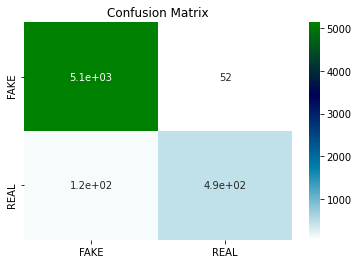

In [52]:
# Visualization of confusion-matrix with a heat-map
# fig = plt.figure(figsize=(10,6))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

sns.heatmap(conf_mat, annot=True, cmap=plt.cm.ocean_r,
            xticklabels=['FAKE','REAL'], 
            yticklabels=['FAKE','REAL'])
plt.show()
